**Цель нашего проекта помочь фермеру принимать объективное решение о покупке бурёнок, для повышения стада коров и увеличить удой. Выбор должен происходить в соответсвтии с определёнными критериями, поэтому для управления рисками мы интегрируем модель машинного обучения. Наши целевые признаки: Удой и Вкус молока**


## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
data_ferm = pd.read_csv('/datasets/ferma_main.csv', sep = ';')
data_ferm_dad = pd.read_csv('/datasets/ferma_dad.csv', sep = ';')
data_cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep = ';')

In [3]:
for data in [data_ferm, data_ferm_dad, data_cow_buy]:
    print(data.head(5))

   id  Удой, кг ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                  14,2              1743   
1   2      5529                                  12,8              2138   
2   3      5810                                    14              1854   
3   4      5895                                  12,4              2012   
4   5      5302                                  12,8              1675   

  СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0,89   Вис Бик Айдиал    Равнинное   
1                                 0,89   Вис Бик Айдиал    Равнинные   
2                                0,885  РефлешнСоверинг    Холмистое   
3                                0,885  РефлешнСоверинг    Холмистое   
4                                0,885   Вис Бик Айдиал    Равнинные   

  порода папы_быка Жирность,% Белок,% Вкус молока      Возраст  
0           Айдиал       3,58   3,076      вкусно  

In [4]:
for data in [data_ferm, data_ferm_dad, data_cow_buy]:
    print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

**Мы вывели 3 датасета и можем заметить, что в некоторых есть пропуски, так же мы видим, что один df содержит данные о стаде фермера, второй хранит имя папы каждой коровы в стаде фермера, третий это данные о коровах «ЭкоФермы». Так же нужно избавиться от пропусков и проверить на дубликаты**

##  Предобработка данных

In [5]:
data_ferm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

In [6]:
data_ferm.head(3)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет


In [7]:
def changes (df, column_name):
    df[column_name] = df[column_name].astype(str).str.replace(',', '.')
    df[column_name] = df[column_name].astype(float)
    return df
def no_skapes (df, column_name):
    df[column_name] = df[column_name].astype(str).str.replace(' ', '_')
    df[column_name] = df[column_name].str.lower()
    return df
def col_name (df):
    new_column_names = {}
    for column in df.columns:
        new_name = column.replace(',', '_')
        new_name = column.replace(' ', '_')
        new_column_names[column] = new_name
    df.rename(columns=new_column_names, inplace=True)
    return df

In [8]:
data_ferm = col_name(data_ferm)

In [9]:
data_ferm.head(3)

,id,"Удой,_кг",ЭКЕ_(Энергетическая_кормовая_единица),"Сырой_протеин,_г",СПО_(Сахаро-протеиновое_соотношение),Порода,Тип_пастбища,порода_папы_быка,"Жирность,%","Белок,%",Вкус_молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет


In [10]:
data_ferm = data_ferm.rename(columns={'Удой,_кг': 'Удой_кг', 'Сырой_протеин,_г': 'Сырой_протеин_г',
                                     'ЭКЕ_(Энергетическая_кормовая_единица)':'ЭКЕ', 'СПО_(Сахаро-протеиновое_соотношение)':'СПО',
                                     'Жирность,%':'Жирность', 'Белок,%':'Белок'})

In [11]:
ch = ['ЭКЕ', 'Сырой_протеин_г', 'СПО', 'Жирность', 'Белок']
for column in ch:
    data_ferm = changes(data_ferm, column)
sk = ['Порода', 'Тип_пастбища', 'порода_папы_быка', 'Вкус_молока']
for column in sk:
    data_ferm = no_skapes(data_ferm, column)

In [12]:
uni = ['Порода', 'Тип_пастбища', 'порода_папы_быка', 'Вкус_молока','Возраст']
for column in uni:
    print(data_ferm[column].unique())
    data_ferm[column] = data_ferm[column].astype(str)
data_ferm['Тип_пастбища'] = data_ferm['Тип_пастбища'].astype(str).str.replace('равнинные', 'равнинное')
data_ferm['порода_папы_быка'] = data_ferm['порода_папы_быка'].astype(str).str.replace('айдиалл', 'айдиал')
data_ferm['Тип_пастбища'].unique()

['вис_бик_айдиал' 'рефлешнсоверинг']
['равнинное' 'равнинные' 'холмистое']
['айдиал' 'соверин' 'айдиалл']
['вкусно' 'не_вкусно']
['более_2_лет' 'менее_2_лет']


array(['равнинное', 'холмистое'], dtype=object)

In [13]:
data_ferm.duplicated().sum()

5

In [14]:
data_ferm = data_ferm.drop_duplicates()

In [15]:
data_ferm.duplicated().sum()

0

In [16]:
data_ferm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                629 non-null    int64  
 1   Удой_кг           629 non-null    int64  
 2   ЭКЕ               629 non-null    float64
 3   Сырой_протеин_г   629 non-null    float64
 4   СПО               629 non-null    float64
 5   Порода            629 non-null    object 
 6   Тип_пастбища      629 non-null    object 
 7   порода_папы_быка  629 non-null    object 
 8   Жирность          629 non-null    float64
 9   Белок             629 non-null    float64
 10  Вкус_молока       629 non-null    object 
 11  Возраст           629 non-null    object 
dtypes: float64(5), int64(2), object(5)
memory usage: 63.9+ KB


**Обработав первый DF мы выявили неявили неявные дубликаты и избавились от них средством замещения. Так же мы привели все значения к единым форматам, убрав верхние регистры и заменив пробелы на нижние прочерки. Так же были изменены названия столбцов для удобства обращения. Судя по дубликатам, кто-то вбил одну и ту же бурёнку несколько раз, видимо ошибка человеческого фактора**

In [17]:
data_ferm_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [18]:
data_ferm_dad = data_ferm_dad.rename(columns={'Имя Папы': 'имя_папы'})
data_ferm_dad = no_skapes(data_ferm_dad,'имя_папы')
data_ferm_dad['имя_папы'].unique()

array(['буйный', 'соловчик', 'барин', 'геркулес'], dtype=object)

In [19]:
data_ferm_dad.duplicated().sum()

0

**Обработав второй ДФ, мы так же привели все данные к одному формату, дубликатов или пропущенных значений нет**

In [20]:
data_cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


In [21]:
col_name(data_cow_buy)
data_cow_buy = data_cow_buy.rename(columns={'Текущая_жирность,%': 'Текущая_жирность','Текущий_уровень_белок,%':'Текущий_уровень_белок'})
data_cow_buy.head(3)

,Порода,Тип_пастбища,порода_папы_быка,Имя_папы,Текущая_жирность,Текущий_уровень_белок,Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет


In [22]:
ch = ['Текущая_жирность', 'Текущий_уровень_белок']
for column in ch:
    data_cow_buy = changes(data_cow_buy, column)
sk = ['Порода', 'Тип_пастбища', 'порода_папы_быка', 'Имя_папы','Возраст']
for column in sk:
    data_cow_buy = no_skapes(data_cow_buy, column)
    print(data_cow_buy[column].unique())

['вис_бик_айдиал' 'рефлешнсоверинг']
['холмистое' 'равнинное']
['айдиал' 'соверин']
['геркулес' 'буйный' 'барин' 'соловчик']
['более_2_лет' 'менее_2_лет']


**Так же привели все данные к змеиному регистру и одному типу. Пропущенных значений нет. Дубликаты в данном случае я не искал, т.к все значения находятся в одном промежутке, из-за чего нельзя исключать, что их совпадения это случайность**


**По итогам подготовки данных мы выяснили, что не всё было записано корректно, но мы успешно с этим справились, привели все датафреймы к единому виду, можно начинать с ними работать**


## Исследовательский анализ данных

In [23]:
data_ferm

,id,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,порода_папы_быка,Жирность,Белок,Вкус_молока,Возраст
0,1,5863,14.2,1743.0,0.890,вис_бик_айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138.0,0.890,вис_бик_айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854.0,0.885,рефлешнсоверинг,холмистое,соверин,3.59,3.074,не_вкусно,более_2_лет
3,4,5895,12.4,2012.0,0.885,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,не_вкусно,более_2_лет
4,5,5302,12.8,1675.0,0.885,вис_бик_айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,15.4,1964.0,0.940,рефлешнсоверинг,равнинное,айдиал,3.74,3.075,не_вкусно,более_2_лет
625,626,5513,12.9,1700.0,0.880,рефлешнсоверинг,равнинное,соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970,14.4,1837.0,0.880,рефлешнсоверинг,холмистое,соверин,3.64,3.075,не_вкусно,более_2_лет
627,628,5746,13.8,1994.0,0.890,рефлешнсоверинг,равнинное,соверин,3.64,3.077,вкусно,более_2_лет


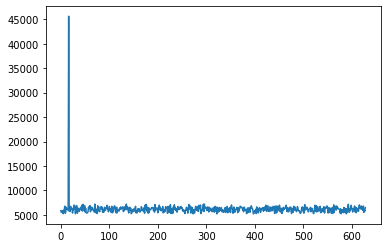

In [24]:
plt.plot(data_ferm['Удой_кг']);

Text(0, 0.5, 'Частота')

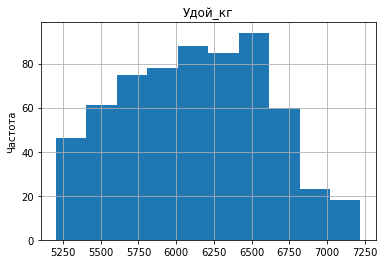

In [25]:
data_ferm = data_ferm.query('0 < Удой_кг < 10000')
data_ferm['Удой_кг'].plot(kind = 'hist', title='Удой_кг', grid = True);
plt.ylabel('Частота')

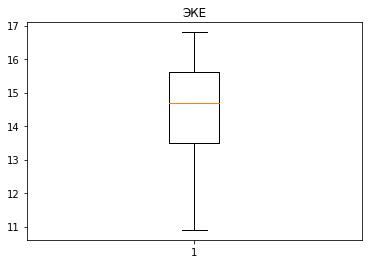

In [26]:
plt.boxplot(data_ferm['ЭКЕ']);
plt.title('ЭКЕ');

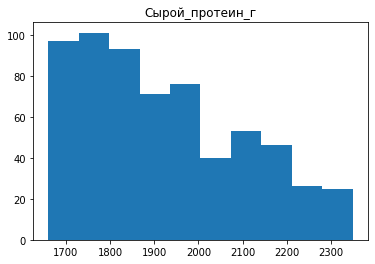

In [27]:
plt.hist(data_ferm['Сырой_протеин_г']);
plt.title('Сырой_протеин_г');

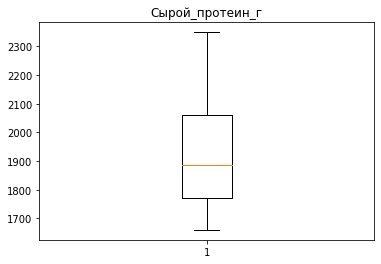

In [28]:
plt.boxplot(data_ferm['Сырой_протеин_г']);
plt.title('Сырой_протеин_г');

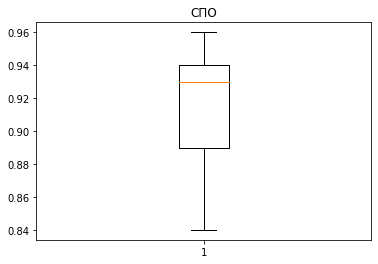

In [29]:
plt.boxplot(data_ferm['СПО']);
plt.title('СПО');

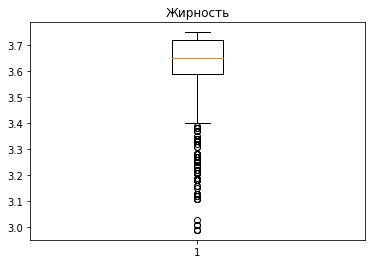

In [30]:
plt.boxplot(data_ferm['Жирность'])
plt.title('Жирность');

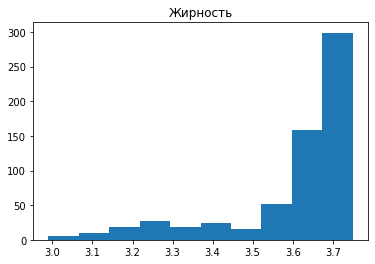

In [31]:
plt.hist(data_ferm['Жирность']);
plt.title('Жирность');

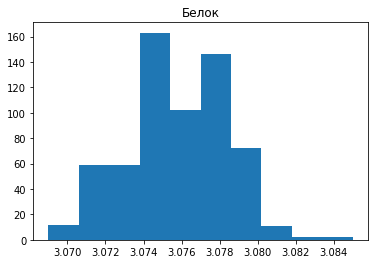

In [32]:
plt.hist(data_ferm['Белок'], bins = 10);
plt.title('Белок');

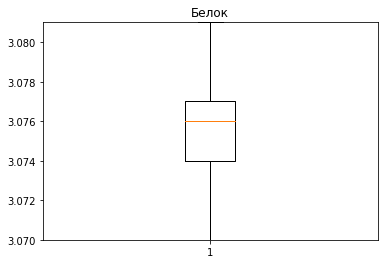

In [33]:
plt.ylim(3.07, 3.081)
plt.boxplot(data_ferm['Белок'])
plt.title('Белок');

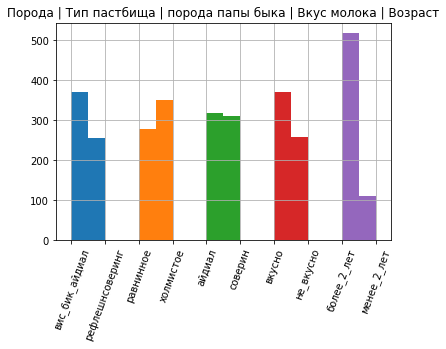

In [34]:
ch = ['Порода', 'Тип_пастбища', 'порода_папы_быка', 'Вкус_молока', 'Возраст']
for column in ch:
    data_ferm[column].hist(bins = 2)
    plt.xticks(rotation=70)
plt.title('Порода | Тип пастбища | порода папы быка | Вкус молока | Возраст');

**По итогам Исследовательского Анализа Данных в первом датафрейме нам удалось избавиться от выбросов и сравнить соотношения всех категоральных величин, что мы можем видеть на графике. По поводу жирности, я не стал удалять то, что на "ящике с усами" указалось как выбросы, т.к жирность молока может быть споконо около 3%, это скорее редкость, чем ошибка. Так же жирность может влиять на вкус, поэтому эти данные пригодятся нам в дальнейшем исследовании**

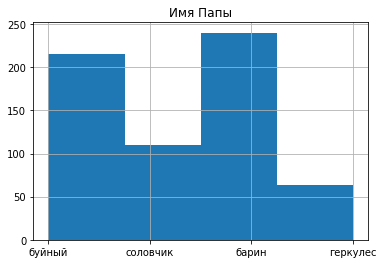

In [35]:
data_ferm_dad['имя_папы'].hist(bins=4)
plt.title('Имя Папы');

**Тут мы можем видеть как распределились так называемые "папы" Бурёнок. Меньше всего потомства у Геркулеса, но я считаю, ничего из ряда вон тут нет**

In [36]:
data_cow_buy

,Порода,Тип_пастбища,порода_папы_быка,Имя_папы,Текущая_жирность,Текущий_уровень_белок,Возраст
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет
1,вис_бик_айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет
6,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет
7,вис_бик_айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет
8,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет


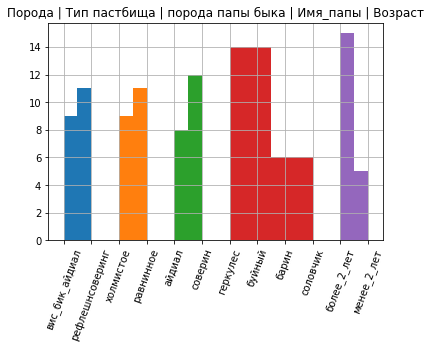

In [37]:
ch = ['Порода', 'Тип_пастбища', 'порода_папы_быка', 'Имя_папы', 'Возраст']
for column in ch:
    data_cow_buy[column].hist(bins = 2)
    plt.xticks(rotation=70)
plt.title('Порода | Тип пастбища | порода папы быка | Имя_папы | Возраст');

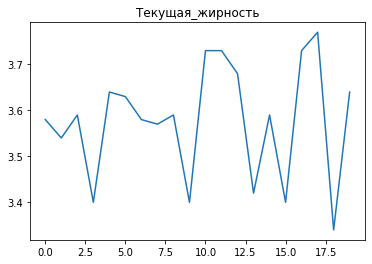

In [38]:
plt.plot(data_cow_buy['Текущая_жирность']);
plt.title('Текущая_жирность');

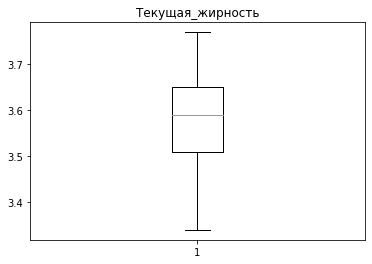

In [39]:
plt.boxplot(data_cow_buy['Текущая_жирность'])
plt.title('Текущая_жирность');

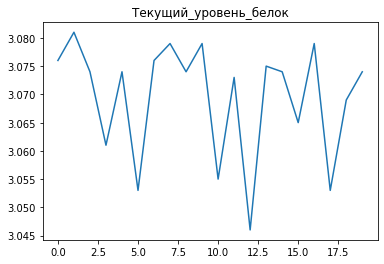

In [40]:
plt.plot(data_cow_buy['Текущий_уровень_белок']);
plt.title('Текущий_уровень_белок');

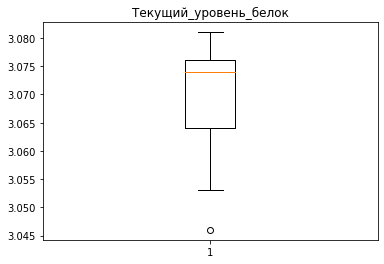

In [41]:
plt.boxplot(data_cow_buy['Текущий_уровень_белок'])
plt.title('Текущий_уровень_белок');

**В результате обработки третьего ДФ, не было обнаружено никаких выбросов или странных значний. Так же мы визуализировали как распределены все признаки**

**Можно начинать подготовку к обучению модели**

## Корреляционный анализ

In [42]:
cor = data_ferm[['Удой_кг','ЭКЕ','Сырой_протеин_г','СПО','Жирность','Белок']].corr()

<AxesSubplot:>

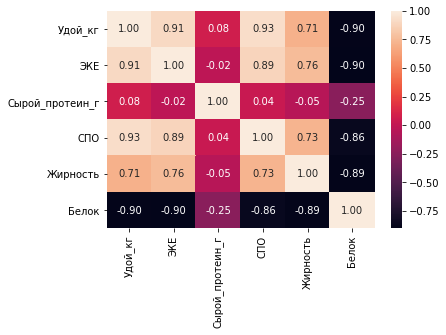

In [43]:
sns.heatmap(cor.corr(), annot = True, fmt = '.2f')

**По матрице Корреляции мы можем заметить, что Удой имеет сильную прямую взаимосвязь с ЭКЕ и СПО. И имеет очень малую прямую связь с Сырым протеином, умеренную с жирностью и практически отсутствующую с Белком. Можно сделать вывод, что чем больше у Бурёнки удой, тем выше значения ЭКЕ и СПО**

In [44]:
data_ferm.head(2)


,id,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,порода_папы_быка,Жирность,Белок,Вкус_молока,Возраст
0,1,5863,14.2,1743.0,0.89,вис_бик_айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138.0,0.89,вис_бик_айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет


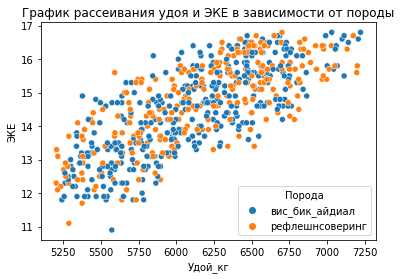

In [45]:
sns.scatterplot(
    data = data_ferm,
    x = data_ferm['Удой_кг'],
    y = data_ferm['ЭКЕ'],
    hue='Порода',
)
plt.title('График рассеивания удоя и ЭКЕ в зависимости от породы')
plt.show()

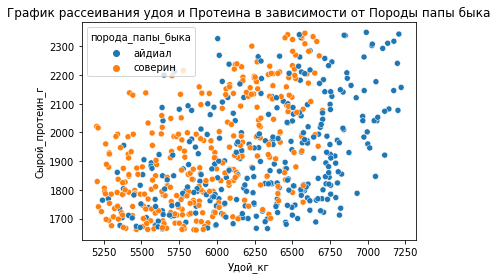

In [46]:
sns.scatterplot(
    data = data_ferm,
    x = data_ferm['Удой_кг'],
    y = data_ferm['Сырой_протеин_г'],
    hue='порода_папы_быка',
)
plt.title('График рассеивания удоя и Протеина в зависимости от Породы папы быка')
plt.show()

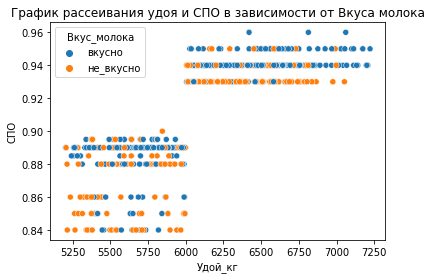

In [47]:
sns.scatterplot(
    data = data_ferm,
    x = data_ferm['Удой_кг'],
    y = data_ferm['СПО'],
    hue='Вкус_молока',
)
plt.title('График рассеивания удоя и СПО в зависимости от Вкуса молока')
plt.show()

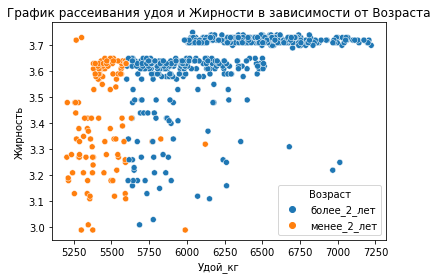

In [48]:
sns.scatterplot(
    data = data_ferm,
    x = data_ferm['Удой_кг'],
    y = data_ferm['Жирность'],
    hue='Возраст',
)
plt.title('График рассеивания удоя и Жирности в зависимости от Возраста')
plt.show()

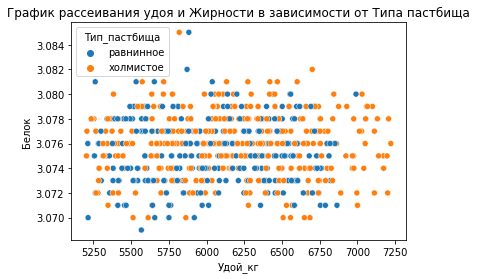

In [49]:
sns.scatterplot(
    data = data_ferm,
    x = data_ferm['Удой_кг'],
    y = data_ferm['Белок'],
    hue='Тип_пастбища',
)
plt.title('График рассеивания удоя и Жирности в зависимости от Типа пастбища')
plt.show()

**В итоге анализа было выявлено, что удой сильно зависит от возраста. Если бурёнка старше 2-ух лет, что её удой значительно больше, чем бурёнка, которая младше 2-ух лет. У вкуса молока же прослеживается зависимость от значения СПО, при высоком его значении, шанс того, что молоко будет вкусным возрастает.**

## Обучение модели линейной регрессии

In [50]:
data_ferm.head(1)

,id,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,порода_папы_быка,Жирность,Белок,Вкус_молока,Возраст
0,1,5863,14.2,1743.0,0.89,вис_бик_айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет


In [51]:
data_ferm_ML_1 = data_ferm.drop(columns = ['Жирность', 'Белок', 'Вкус_молока'], axis = 1)

**Были выбраны эти признаки по причине отсутсвтвия у них прямой линейной связи с целевым признаком, так же у некоторых из них есть связь с другими признаками**

In [52]:
RANDOM_STATE = 42

In [53]:
data_ferm_ML_1['Удой_кг'] = data_ferm_ML_1['Удой_кг'].astype(float)

In [54]:
data_ferm_ML_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                628 non-null    int64  
 1   Удой_кг           628 non-null    float64
 2   ЭКЕ               628 non-null    float64
 3   Сырой_протеин_г   628 non-null    float64
 4   СПО               628 non-null    float64
 5   Порода            628 non-null    object 
 6   Тип_пастбища      628 non-null    object 
 7   порода_папы_быка  628 non-null    object 
 8   Возраст           628 non-null    object 
dtypes: float64(4), int64(1), object(4)
memory usage: 49.1+ KB


In [55]:
X = data_ferm_ML_1.drop('Удой_кг', axis = 1)
y = data_ferm_ML_1['Удой_кг']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [56]:
encoder1 = OneHotEncoder(drop='first', sparse=False)
col_for_en = ['Порода','Тип_пастбища','порода_папы_быка','Возраст']
X_train_ohe = encoder1.fit_transform(X_train[col_for_en]) 
X_test_ohe = encoder1.transform(X_test[col_for_en])
print("Форма X_train_ohe:", X_train_ohe.shape)
print("Форма X_test_ohe:", X_test_ohe.shape)

Форма X_train_ohe: (471, 4)
Форма X_test_ohe: (157, 4)


In [57]:
scaler1 = StandardScaler()
col_for_sc = ['Сырой_протеин_г','СПО']
X_train_scaler = scaler1.fit_transform(X_train[col_for_sc])
X_test_scaler = scaler1.transform(X_test[col_for_sc])
print("Форма X_train_scaled:", X_train_scaler.shape)
print("Форма X_test_scaled:", X_test_scaler.shape)

Форма X_train_scaled: (471, 2)
Форма X_test_scaled: (157, 2)


In [58]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=col_for_en)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=col_for_en)
X_train_scaler = pd.DataFrame(X_train_scaler, columns=col_for_sc)
X_test_scaler = pd.DataFrame(X_test_scaler, columns=col_for_sc)

In [59]:
X_train = pd.concat([X_train_ohe, X_train_scaler], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaler], axis=1)

In [60]:
X_test

,Порода,Тип_пастбища,порода_папы_быка,Возраст,Сырой_протеин_г,СПО
0,0.0,1.0,0.0,0.0,-0.813322,-1.011818
1,1.0,1.0,1.0,0.0,0.026730,0.837130
2,1.0,1.0,1.0,1.0,-0.682405,-1.628134
3,0.0,0.0,1.0,0.0,-1.058792,-1.011818
4,0.0,1.0,1.0,0.0,-1.413360,-0.703660
...,...,...,...,...,...,...
152,0.0,1.0,0.0,0.0,0.506760,0.528972
153,1.0,1.0,0.0,0.0,0.714046,0.837130
154,0.0,0.0,0.0,0.0,0.114008,0.837130
155,0.0,0.0,0.0,0.0,-0.415116,-0.549581


In [61]:
model_lr_1 = LinearRegression()
model_lr_1.fit(X_train, y_train)
predictions_1 = model_lr_1.predict(X_test)
print("Форма y_test:", y_test.shape)
print("Форма predictions:", predictions_1.shape)

Форма y_test: (157,)
Форма predictions: (157,)


In [62]:
r2_1 = r2_score(y_test, predictions_1) 
print("R2 LinearRegression =", r2_1)

R2 LinearRegression = 0.7417971364942788


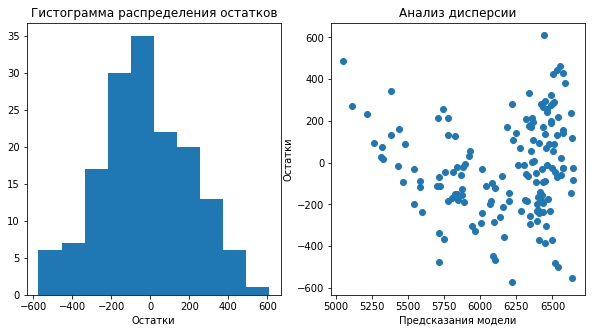

In [63]:
residuals = y_test - predictions_1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_1,residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

##### **Модель предоставляет правильный ответ более чем в 75% случаев. Исходя из Анализа остатков, распределение смещено вправо, модель занижает прогнозные значения, так же у анализа дисперсии остатков неравномерное распределение. Возможно это связано с тем что признаки коррелируются между собой. Нужны дополнительные исследования.**

In [64]:
data_ferm.head(1)

,id,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,порода_папы_быка,Жирность,Белок,Вкус_молока,Возраст
0,1,5863,14.2,1743.0,0.89,вис_бик_айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет


In [65]:
data_ferm_ML_2 = data_ferm.drop(columns = ['id','Жирность', 'Белок', 'Вкус_молока'], axis = 1)

In [66]:
data_ferm_ML_2.head(1)


,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,порода_папы_быка,Возраст
0,5863,14.2,1743.0,0.89,вис_бик_айдиал,равнинное,айдиал,более_2_лет


In [67]:
data_ferm_ML_2['СПО'] = np.where(data_ferm['СПО'] >= 0.90, 'высокое_значение', 'низкое_значение')
data_ferm_ML_2['ЭКЕ'] = np.square(data_ferm['ЭКЕ'])
data_ferm_ML_2

,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,порода_папы_быка,Возраст
0,5863,201.64,1743.0,низкое_значение,вис_бик_айдиал,равнинное,айдиал,более_2_лет
1,5529,163.84,2138.0,низкое_значение,вис_бик_айдиал,равнинное,соверин,менее_2_лет
2,5810,196.00,1854.0,низкое_значение,рефлешнсоверинг,холмистое,соверин,более_2_лет
3,5895,153.76,2012.0,низкое_значение,рефлешнсоверинг,холмистое,айдиал,более_2_лет
4,5302,163.84,1675.0,низкое_значение,вис_бик_айдиал,равнинное,соверин,менее_2_лет
...,...,...,...,...,...,...,...,...
624,6812,237.16,1964.0,высокое_значение,рефлешнсоверинг,равнинное,айдиал,более_2_лет
625,5513,166.41,1700.0,низкое_значение,рефлешнсоверинг,равнинное,соверин,менее_2_лет
626,5970,207.36,1837.0,низкое_значение,рефлешнсоверинг,холмистое,соверин,более_2_лет
627,5746,190.44,1994.0,низкое_значение,рефлешнсоверинг,равнинное,соверин,более_2_лет


In [68]:
encoder2 = OneHotEncoder(drop='first', sparse=False)
scaler2 = StandardScaler()
X = data_ferm_ML_2.drop('Удой_кг', axis = 1)
y = data_ferm_ML_2['Удой_кг']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
col_for_en = ['Порода','Тип_пастбища','порода_папы_быка','Возраст','СПО']
col_for_sc = ['Сырой_протеин_г','ЭКЕ']
X_train_ohe = encoder2.fit_transform(X_train[col_for_en]) 
X_test_ohe = encoder2.transform(X_test[col_for_en]) 
X_train_scaler = scaler2.fit_transform(X_train[col_for_sc])
X_test_scaler = scaler2.transform(X_test[col_for_sc])
X_train_ohe = pd.DataFrame(X_train_ohe, columns=col_for_en)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=col_for_en)
X_train_scaler = pd.DataFrame(X_train_scaler, columns=col_for_sc)
X_test_scaler = pd.DataFrame(X_test_scaler, columns=col_for_sc)
X_train = pd.concat([X_train_ohe, X_train_scaler], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaler], axis=1)
model_lr_2 = LinearRegression()
model_lr_2.fit(X_train, y_train)
predictions_2 = model_lr_2.predict(X_test)
print("Форма y_test:", y_test.shape)
print("Форма predictions:", predictions_2.shape)

Форма y_test: (157,)
Форма predictions: (157,)


In [69]:
X_test

,Порода,Тип_пастбища,порода_папы_быка,Возраст,СПО,Сырой_протеин_г,ЭКЕ
0,0.0,1.0,0.0,0.0,1.0,-0.813322,-0.527089
1,1.0,1.0,1.0,0.0,0.0,0.026730,1.490346
2,1.0,1.0,1.0,1.0,1.0,-0.682405,-0.527089
3,0.0,0.0,1.0,0.0,1.0,-1.058792,-0.961737
4,0.0,1.0,1.0,0.0,1.0,-1.413360,0.561660
...,...,...,...,...,...,...,...
152,0.0,1.0,0.0,0.0,0.0,0.506760,1.754809
153,1.0,1.0,0.0,0.0,0.0,0.714046,0.643423
154,0.0,0.0,0.0,0.0,0.0,0.114008,0.561660
155,0.0,0.0,0.0,0.0,1.0,-0.415116,0.239936


In [70]:
r2_2 = r2_score(y_test, predictions_2) 
print("R2 LinearRegression =", r2_2)

R2 LinearRegression = 0.8177696341282361


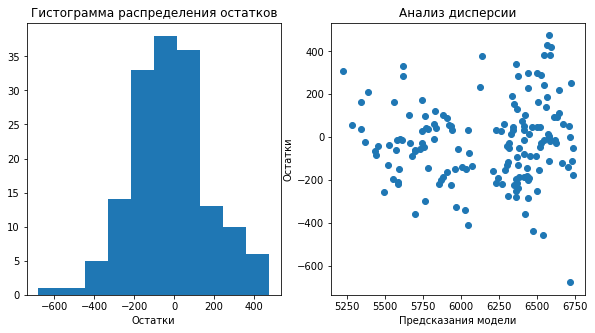

In [71]:
residuals = y_test - predictions_2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_2,residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Разделение нелинейных зависимость на кластеры помогло улучшить качество модели, теперь она меньше ошибается и даёт верные результаты, однако форма рассеивания дисперсий всё ещё оставляет желать лучшего. Нужно дальше проводить исследования с моделями**

In [72]:
data_ferm_for_3 = pd.merge(data_ferm, data_ferm_dad, on = 'id', how ='inner')

In [73]:
data_ferm_for_3 = data_ferm_for_3.dropna()
data_ferm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                628 non-null    int64  
 1   Удой_кг           628 non-null    int64  
 2   ЭКЕ               628 non-null    float64
 3   Сырой_протеин_г   628 non-null    float64
 4   СПО               628 non-null    float64
 5   Порода            628 non-null    object 
 6   Тип_пастбища      628 non-null    object 
 7   порода_папы_быка  628 non-null    object 
 8   Жирность          628 non-null    float64
 9   Белок             628 non-null    float64
 10  Вкус_молока       628 non-null    object 
 11  Возраст           628 non-null    object 
dtypes: float64(5), int64(2), object(5)
memory usage: 63.8+ KB


In [74]:
data_ferm_ML_3 = data_ferm_for_3.drop(columns = ['Жирность', 'Белок', 'Вкус_молока'], axis = 1)

In [75]:
data_ferm_ML_3.head(1)

,id,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,порода_папы_быка,Возраст,имя_папы
0,1,5863,14.2,1743.0,0.89,вис_бик_айдиал,равнинное,айдиал,более_2_лет,буйный


In [76]:
data_ferm_ML_3['СПО'] = np.where(data_ferm['СПО'] >= 0.90, 'высокое_значение', 'низкое_значение')
data_ferm_ML_3['ЭКЕ'] = np.square(data_ferm['ЭКЕ'])
X = data_ferm_ML_3.drop('Удой_кг', axis = 1)
y = data_ferm_ML_3['Удой_кг']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
col_for_en = ['Порода','Тип_пастбища','порода_папы_быка','Возраст','СПО','имя_папы']
col_for_sc = ['Сырой_протеин_г','ЭКЕ']
encoder3 = OneHotEncoder(drop='first', sparse=False)
scaler3 = StandardScaler()
X_train_ohe = encoder3.fit_transform(X_train[col_for_en]) 
X_test_ohe = encoder3.transform(X_test[col_for_en]) 
X_train_scaler = scaler3.fit_transform(X_train_ohe)
X_test_scaler = scaler3.transform(X_test_ohe)
model_lr_3 = LinearRegression()
model_lr_3.fit(X_train_scaler, y_train)
predictions_3 = model_lr_3.predict(X_test_scaler)
print("Форма y_test:", y_test.shape)
print("Форма predictions:", predictions_3.shape)

Форма y_test: (157,)
Форма predictions: (157,)


In [77]:
r2_3 = r2_score(y_test, predictions_3) 
print("R2 LinearRegression =", r2_3)

R2 LinearRegression = 0.790070184481943


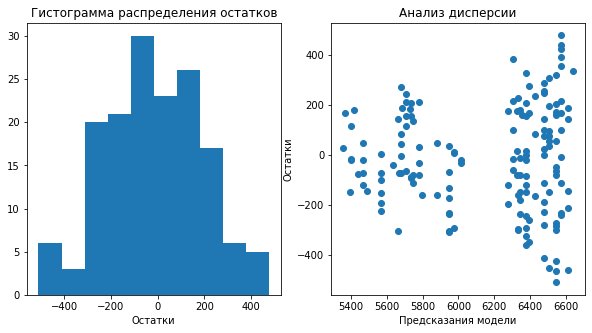

In [78]:
residuals = y_test - predictions_3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_3,residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**После добавления нового признака качество работы модели ухудшилоь, она начала больше ошибаться, Анализ диспперсии тоже начал выглядеть хуже, видимо добавление признака негативно повлияло на модель**

In [79]:
print("R2 первой модели", r2_1)
print("R2 второй модели", r2_2)
print("R2 Третьей модели", r2_3)
print('-------------------------------------')
print("МSE первой модели", mean_squared_error(y_test, predictions_1))
print("МSE второй модели", mean_squared_error(y_test, predictions_2))
print("МSE Третьей модели", mean_squared_error(y_test, predictions_3))
print('-------------------------------------')
print("MAE первой модели", mean_absolute_error(y_test, predictions_1))
print("MAE второй модели", mean_absolute_error(y_test, predictions_2))
print("MAE Третьей модели", mean_absolute_error(y_test, predictions_3))
print('-------------------------------------')
print("RMSE первой модели", mean_squared_error(y_test, predictions_1, squared=False))
print("RMSE второй модели", mean_squared_error(y_test, predictions_2, squared=False))
print("RMSE Третьей модели", mean_squared_error(y_test, predictions_3, squared=False))

R2 первой модели 0.7417971364942788
R2 второй модели 0.8177696341282361
R2 Третьей модели 0.790070184481943
-------------------------------------
МSE первой модели 52561.05674375425
МSE второй модели 37095.717959799644
МSE Третьей модели 42734.35544376123
-------------------------------------
MAE первой модели 187.12948172943703
MAE второй модели 149.15000962733413
MAE Третьей модели 169.4951301509836
-------------------------------------
RMSE первой модели 229.2619827702671
RMSE второй модели 192.60248689931197
RMSE Третьей модели 206.72289530615913


**Если сравнивать, то вторая модель лучше всего справляется, у неё наивысший процент правильно предсказанных значений и она меньше всего ошибается. Можно применить её на неё выборку потенциальных для покупки коров**

In [80]:
col_for_add = ['ЭКЕ','СПО','Сырой_протеин_г']
col = ['ЭКЕ','Сырой_протеин_г']
data_cow_buy_ML_final = data_cow_buy.drop(columns = ['Имя_папы','Текущая_жирность', 'Текущий_уровень_белок'], axis = 1)
data_cow_buy_ML_final[col_for_add] = data_ferm[col_for_add].mean() * 1.05
data_cow_buy_ML_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Порода            20 non-null     object 
 1   Тип_пастбища      20 non-null     object 
 2   порода_папы_быка  20 non-null     object 
 3   Возраст           20 non-null     object 
 4   ЭКЕ               20 non-null     float64
 5   СПО               20 non-null     float64
 6   Сырой_протеин_г   20 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.2+ KB


In [81]:
data_cow_buy_ML_final['СПО'] = np.where(data_cow_buy_ML_final['СПО'] > 0.90, 'высокое_значение', 'низкое_значение')
data_cow_buy_ML_final['ЭКЕ'] = np.square(data_cow_buy_ML_final['ЭКЕ'])

In [82]:
data_cow_buy_ML_final
col_for_en = ['Порода','Тип_пастбища','порода_папы_быка','Возраст','СПО']

In [83]:
col_for_en = ['Порода','Тип_пастбища','порода_папы_быка','Возраст','СПО']
col_for_sc = ['Сырой_протеин_г','ЭКЕ']
data_cow_buy_ML_final_ohe = encoder2.transform(data_cow_buy_ML_final[col_for_en]) 
data_cow_buy_ML_final_scaler = scaler2.transform(data_cow_buy_ML_final[col_for_sc])
print("Форма y_test:", data_cow_buy_ML_final_ohe.shape)
print("Форма predictions:", data_cow_buy_ML_final_scaler.shape)

Форма y_test: (20, 5)
Форма predictions: (20, 2)


In [84]:
data_cow_buy_ML_final_ohe = pd.DataFrame(data_cow_buy_ML_final_ohe, columns=col_for_en)
data_cow_buy_ML_final_scaler = pd.DataFrame(data_cow_buy_ML_final_scaler, columns=col_for_sc)
data_cow_buy_ML_final = pd.concat([data_cow_buy_ML_final_ohe, data_cow_buy_ML_final_scaler], axis=1)
data_cow_buy_ML_final

,Порода,Тип_пастбища,порода_папы_быка,Возраст,СПО,Сырой_протеин_г,ЭКЕ
0,0.0,1.0,0.0,0.0,0.0,0.517384,0.542248
1,0.0,0.0,1.0,1.0,0.0,0.517384,0.542248
2,1.0,0.0,1.0,0.0,0.0,0.517384,0.542248
3,1.0,1.0,0.0,0.0,0.0,0.517384,0.542248
4,1.0,0.0,0.0,0.0,0.0,0.517384,0.542248
5,1.0,0.0,1.0,1.0,0.0,0.517384,0.542248
6,0.0,1.0,0.0,0.0,0.0,0.517384,0.542248
7,0.0,0.0,1.0,0.0,0.0,0.517384,0.542248
8,1.0,0.0,1.0,0.0,0.0,0.517384,0.542248
9,1.0,1.0,0.0,1.0,0.0,0.517384,0.542248


In [85]:
predictions_main = model_lr_2.predict(data_cow_buy_ML_final)

In [86]:
data_cow_buy['Удой'] = predictions_main

In [87]:
data_cow_buy[(data_cow_buy['Удой'] > 6000)]['Удой'].count()

20

**Подходящих под требование фермера коров: 10**

## Обучение модели логистической регрессии

In [88]:
data_ferm_ML_4 = data_ferm.drop(columns = ['Удой_кг'], axis = 1)

In [89]:
data_ferm_ML_4['СПО'] = np.where(data_ferm_ML_4['СПО'] >= 0.90, 'высокое_значение', 'низкое_значение')
data_ferm_ML_4['ЭКЕ'] = np.square(data_ferm_ML_4['ЭКЕ'])
data_ferm_ML_4['Вкус_молока'] = np.where(data_ferm_ML_4['Вкус_молока'] == 'вкусно', 1, 0)
data_ferm_ML_4.head(2)

,id,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,порода_папы_быка,Жирность,Белок,Вкус_молока,Возраст
0,1,201.64,1743.0,низкое_значение,вис_бик_айдиал,равнинное,айдиал,3.58,3.076,1,более_2_лет
1,2,163.84,2138.0,низкое_значение,вис_бик_айдиал,равнинное,соверин,3.54,3.079,1,менее_2_лет


In [90]:
col_for_en = ['Порода', 'Тип_пастбища', 'порода_папы_быка', 'Возраст', 'СПО']

In [91]:
col_for_sc = ['Сырой_протеин_г','Жирность','Белок','ЭКЕ']

In [92]:
X = data_ferm_ML_4.drop('Вкус_молока', axis = 1)
y = data_ferm_ML_4['Вкус_молока']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
encoder4 = OneHotEncoder(drop='first', sparse=False)
scaler4 = StandardScaler()
X_train_ohe = encoder4.fit_transform(X_train[col_for_en]) 
X_test_ohe = encoder4.transform(X_test[col_for_en]) 
X_train_scaler = scaler4.fit_transform(X_train[col_for_sc])
X_test_scaler = scaler4.transform(X_test[col_for_sc])
X_train_ohe = pd.DataFrame(X_train_ohe, columns=col_for_en)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=col_for_en)
X_train_scaler = pd.DataFrame(X_train_scaler, columns=col_for_sc)
X_test_scaler = pd.DataFrame(X_test_scaler, columns=col_for_sc)
X_train = pd.concat([X_train_ohe, X_train_scaler], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaler], axis=1)
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions_1 = clf.predict(X_test)
print("Форма y_test:", y_test.shape)
print("Форма predictions:", predictions_1.shape)

Форма y_test: (157,)
Форма predictions: (157,)


In [93]:
X_train

,Порода,Тип_пастбища,порода_папы_быка,Возраст,СПО,Сырой_протеин_г,Жирность,Белок,ЭКЕ
0,1.0,1.0,1.0,0.0,0.0,1.079523,0.562532,-0.679069,1.577968
1,1.0,1.0,1.0,1.0,1.0,-0.196920,-1.601817,-1.452568,-1.511438
2,0.0,0.0,0.0,0.0,1.0,-1.386085,-2.563750,1.254677,0.082269
3,0.0,1.0,0.0,0.0,0.0,0.752230,0.081565,1.254677,-0.150235
4,0.0,0.0,0.0,0.0,1.0,0.828598,0.201807,0.094429,-1.102358
...,...,...,...,...,...,...,...,...,...
466,1.0,1.0,0.0,0.0,1.0,1.565008,0.021444,0.481179,-0.674102
467,0.0,0.0,0.0,0.0,0.0,-0.998788,0.682773,-1.065819,0.239936
468,1.0,0.0,0.0,0.0,1.0,-0.818777,0.141686,-1.839317,-0.890627
469,0.0,0.0,0.0,0.0,1.0,0.130373,0.021444,-0.292320,-1.102358


In [94]:
print("accuracy модели", accuracy_score(y_test, predictions_1))
print("recall модели", recall_score(y_test, predictions_1))
print("precision модели", precision_score(y_test, predictions_1))

accuracy модели 0.6305732484076433
recall модели 0.8522727272727273
precision модели 0.625


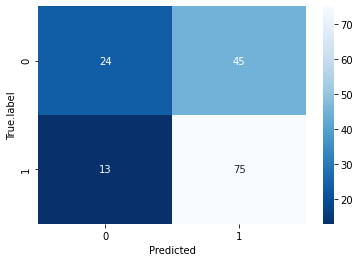

In [95]:
cm = confusion_matrix (y_test, predictions_1)
sns.heatmap(cm, annot = True, fmt = 'd', cmap ='Blues_r')
plt.ylabel('True.label')
plt.xlabel('Predicted');

**В данном случае метрика precision для нас более важна, т.к для фермера вкус молока это важный аспект. Значит нам нужно добавить порог проходимости, чтобы модель максимально точно выявила вкусное молоко**

In [96]:
thresholds = [round(i,2) for i in np.linspace(0.01,1,num = 100,endpoint=False)]
y_proba = clf.predict_proba(X_test)[:,1]
columns = []
data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_test', 'y_proba']).sort_values(by='y_proba',ascending=False)
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
print(data.sample(5))
y_true = data['y_test']
precision_scores = []
for i in thresholds:
    y_pred = (data['y_proba'] >= i).astype(int)  # Применение порога
    precision = precision_score(y_true, y_pred)  # Вычисление precision
    precision_scores.append(precision)
    print(f"Threshold: {i}, Precision: {precision}")

     y_test   y_proba  y_pred_0.01  y_pred_0.02  y_pred_0.03  y_pred_0.04  \
18        1  0.753178            1            1            1            1   
78        0  0.680548            1            1            1            1   
130       0  0.511375            1            1            1            1   
25        1  0.760182            1            1            1            1   
128       1  0.643279            1            1            1            1   

     y_pred_0.05  y_pred_0.06  y_pred_0.07  y_pred_0.08  ...  y_pred_0.9  \
18             1            1            1            1  ...           0   
78             1            1            1            1  ...           0   
130            1            1            1            1  ...           0   
25             1            1            1            1  ...           0   
128            1            1            1            1  ...           0   

     y_pred_0.91  y_pred_0.92  y_pred_0.93  y_pred_0.94  y_pred_0.95  \
18      

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined a

**В данном случае нужно применять порог Precision равный 0.1 т.к это наивысшее значение которого мы смогли добиться. При этом значении наибольшее кол-во "вкусного молока" попадёт в руки фермера и наименьшее кол-во "не вкусного".**

In [97]:
data_cow_buy
col_for_sc = ['Сырой_протеин_г','Текущая_жирность','Текущий_уровень_белок','ЭКЕ']

In [98]:
optimal_threshold = 0.7
col_for_add = ['СПО','Сырой_протеин_г','ЭКЕ']

data_cow_buy_ML_final_2 = data_cow_buy
data_cow_buy_ML_final_2[col_for_add] = data_ferm[col_for_add].mean() * 1.05

data_cow_buy_ML_final_2.info()
data_cow_buy_ML_final_2['СПО'] = np.where(data_cow_buy_ML_final_2['СПО'] >= 0.90, 'высокое_значение', 'низкое_значение')
data_cow_buy_ML_final_2['ЭКЕ'] = np.square(data_cow_buy_ML_final_2['ЭКЕ'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Порода                 20 non-null     object 
 1   Тип_пастбища           20 non-null     object 
 2   порода_папы_быка       20 non-null     object 
 3   Имя_папы               20 non-null     object 
 4   Текущая_жирность       20 non-null     float64
 5   Текущий_уровень_белок  20 non-null     float64
 6   Возраст                20 non-null     object 
 7   Удой                   20 non-null     float64
 8   СПО                    20 non-null     float64
 9   Сырой_протеин_г        20 non-null     float64
 10  ЭКЕ                    20 non-null     float64
dtypes: float64(6), object(5)
memory usage: 1.8+ KB


In [99]:
data_cow_buy_ML_final_2_ohe = encoder4.transform(data_cow_buy_ML_final_2[col_for_en]) 
data_cow_buy_ML_final_2_scaler = scaler4.transform(data_cow_buy_ML_final_2[col_for_sc])

data_cow_buy_ML_final_2_ohe = pd.DataFrame(data_cow_buy_ML_final_2_ohe, columns=col_for_en)
data_cow_buy_ML_final_2_scaler = pd.DataFrame(data_cow_buy_ML_final_2_scaler, columns=col_for_sc)
data_cow_buy_ML_final_2 = pd.concat([data_cow_buy_ML_final_2_ohe, data_cow_buy_ML_final_2_scaler], axis=1)



In [100]:
data_cow_buy_ML_final_2

,Порода,Тип_пастбища,порода_папы_быка,Возраст,СПО,Сырой_протеин_г,Текущая_жирность,Текущий_уровень_белок,ЭКЕ
0,0.0,1.0,0.0,0.0,0.0,0.517384,-0.158918,0.094429,0.542248
1,0.0,0.0,1.0,1.0,0.0,0.517384,-0.399401,2.028176,0.542248
2,1.0,0.0,1.0,0.0,0.0,0.517384,-0.098797,-0.679069,0.542248
3,1.0,1.0,0.0,0.0,0.0,0.517384,-1.241093,-5.706810,0.542248
4,1.0,0.0,0.0,0.0,0.0,0.517384,0.201807,-0.679069,0.542248
5,1.0,0.0,1.0,1.0,0.0,0.517384,0.141686,-8.800805,0.542248
6,0.0,1.0,0.0,0.0,0.0,0.517384,-0.158918,0.094429,0.542248
7,0.0,0.0,1.0,0.0,0.0,0.517384,-0.219039,1.254677,0.542248
8,1.0,0.0,1.0,0.0,0.0,0.517384,-0.098797,-0.679069,0.542248
9,1.0,1.0,0.0,1.0,0.0,0.517384,-1.241093,1.254677,0.542248


In [101]:

y_proba_new = clf.predict_proba(data_cow_buy_ML_final_2)[:, 1]
y_pred_new = (y_proba_new >= optimal_threshold).astype(int)
y_pred_labels = np.where(y_pred_new == 1, 'вкусно', 'не_вкусно')
data_cow_buy['вкус'] = y_pred_labels

In [102]:
data_cow_buy = data_cow_buy.drop(columns = ['СПО'], axis = 1)
good_cows = data_cow_buy.query('Удой > 6000 and вкус == "вкусно"')
good_cows.count()

Порода                   4
Тип_пастбища             4
порода_папы_быка         4
Имя_папы                 4
Текущая_жирность         4
Текущий_уровень_белок    4
Возраст                  4
Удой                     4
Сырой_протеин_г          4
ЭКЕ                      4
вкус                     4
dtype: int64

## Итоговые выводы

**Мы смогли подобрать коров по всем необходимым критериям фермера. Удой выше 6кг и вкусное молоко. Из стада можно купить четырёх коров с минимальными рисками. Мы настроили модели на крайнюю чувствительность к вкусу молока, а Удой выдаёттся с точностью 84%**

**Для улучшения качества регрессионой модели были использованы масштабирование, кодирование, приведение к линейной зависимости данных, предобработка и настройка модели. Конечно данные можно ещё улучшить добавив бОльшую выборку или добавив ещё признаков, которых у нас ещё не было. Для рассчётов рисков и экономических рассчётов мы применяли метрики precision и recall. Они на данный момент моих знаний лучше всего справляются с этими задачами**